In [1]:
import numpy as np
import networkx as nx
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import degree, get_laplacian, from_networkx, from_scipy_sparse_matrix
from experiments.sol_propagator import PDESolutionPropogator
from experiments.cheby_poly_layer import ChebyLayer
from experiments.pde_layers import get_cheby_coefs_heat, get_cheby_coefs_wave
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

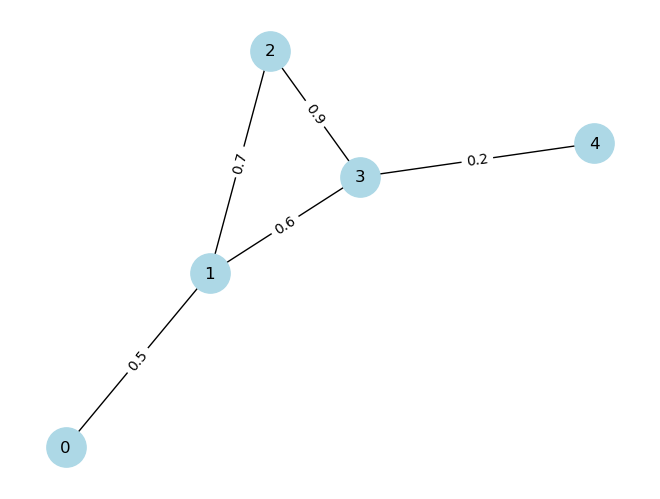

In [2]:
def edge_index_to_adjacency(edge_index, edge_weight, num_nodes):
    adjacency_matrix = torch.zeros((num_nodes, num_nodes))
    adjacency_matrix[edge_index[0], edge_index[1]] = edge_weight
    adjacency_matrix[edge_index[1], edge_index[0]] = edge_weight  # For undirected graph
    return adjacency_matrix

# Create an empty undirected graph
G = nx.Graph()

# Add nodes to the graph
G.add_nodes_from([0, 1, 2, 3, 4])

# Add weighted edges to the graph
G.add_weighted_edges_from([(0, 1, 0.5), (1, 2, 0.7), (1, 3, 0.6), (2, 3, 0.9), (3, 4, 0.2)])

# Visualize the graph with labels
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=800, node_color='lightblue')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

# Show the plot
plt.show()

laplacian_mat = nx.normalized_laplacian_matrix(G).tocsc()

graphinfo = from_networkx(G)
edge_index, edge_weight = graphinfo.edge_index, graphinfo.weight

In [3]:
x = torch.rand((G.number_of_nodes(), 1, 1), device=device, dtype=torch.float)
y = torch.rand((G.number_of_nodes(), 1, 1), device=device, dtype=torch.float)
ts = torch.linspace(0, 10, 100).float().to(device)

In [4]:
oper = PDESolutionPropogator(laplacian_mat, device, eps=1e-5)
yHeat = oper.propogateHeat(x, ts, c=1.).squeeze()
yWave = oper.propogateWave(x, y, ts, c=1.).squeeze()

In [5]:
chebylayer = ChebyLayer(edge_index, edge_weight)
coefs_heat = get_cheby_coefs_heat(ts, degree=100, N=1000)
coefs_wavex, coefs_wavey = get_cheby_coefs_wave(ts, degree=100,  N=1000)
yHeat2 = chebylayer(x, coefs_heat).squeeze()
yWave2 = chebylayer(x, coefs_wavex).squeeze() + chebylayer(y, coefs_wavey).squeeze()

In [6]:
torch.abs(yHeat - yHeat2).max()

tensor(6.5565e-06)

In [7]:
torch.abs(yWave - yWave2).max()

tensor(5.5313e-05)